In [1]:
import numpy as np
import causaldag as cd
import os

In [2]:
from strategies.information_gain import create_info_gain_strategy_dag_collection
from strategies.random_nodes import random_strategy
from strategies.simulator import IterationData
from utils.graph_utils import RAND_RANGE, dag_posterior, cov2dag
from config import DATA_FOLDER, FIGURES_FOLDER

RESULTS_FOLDER = os.path.join(DATA_FOLDER, 'fig1')

In [3]:
nsamples = 100
nsamples_obs = 1000

# Graph

In [4]:
nnodes = 11
source = 5
nodes = list(range(nnodes))

In [5]:
arcs = {(i+1, i) for i in range(source)} | {(i, i+1) for i in range(source, nnodes-1)}
arc_weights = {(i, j): RAND_RANGE() for i, j in arcs}
gdag = cd.GaussDAG(nodes=list(range(nnodes)), arcs=arc_weights)

In [6]:
cpdag = cd.DAG(nodes=set(nodes), arcs=arcs).cpdag()
mec = [cd.DAG(nodes=set(nodes), arcs=arcs) for arcs in cpdag.all_dags()]
print('Size of MEC:', len(mec))

Size of MEC: 11


# Interventions

In [7]:
intervention_nodes = nodes
interventions = [
    cd.GaussIntervention(
        mean=0,
        variance=.1,
    ) for _ in gdag.nodes
]

# Objective

In [8]:
def get_mec_functional(dag_collection):
    def get_dag_ix_mec(dag):
        return next(d_ix for d_ix, d in enumerate(dag_collection) if d.arcs == dag.arcs)
    return get_dag_ix_mec


def get_k_entropy_fxn(k):
    def get_k_entropy(fvals, weights):
        # find probs
        probs = np.zeros(k)
        for fval, w in zip(fvals, weights):
            probs[fval] += w

        # = find entropy
        mask = probs != 0
        plogps = np.zeros(len(probs))
        plogps[mask] = np.log2(probs[mask]) * probs[mask]
        ent = -plogps.sum()
        return ent

    return get_k_entropy

# Strategies

In [9]:
nsamples = 100
obs_samples = gdag.sample(1000)
sample_covariance = obs_samples.T @ obs_samples / obs_samples.shape[0]
sample_precision = np.linalg.inv(sample_covariance)
mec_gauss = [cov2dag(gdag.covariance, dag) for dag in mec]
max_interventions = None
num_runs = 50

### Information Gain with MEC Enumeration

In [10]:
minibatch_size = 5

In [11]:
info_strat = create_info_gain_strategy_dag_collection(
    mec, 
    [get_mec_functional(mec)], 
    [get_k_entropy_fxn(len(mec))], 
    gauss_iv=True,
    minibatch_size=minibatch_size
)

info_strat_folder = os.path.join(RESULTS_FOLDER, 'info')
os.makedirs(info_strat_folder, exist_ok=True)

iteration_data_info_strat = IterationData(
    current_data={-1: obs_samples},
    max_interventions=max_interventions,
    n_samples=nsamples,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=info_strat_folder,
    precision_matrix=sample_precision
)

### Random

In [12]:
iteration_data_random = IterationData(
    current_data={-1: obs_samples},
    max_interventions=max_interventions,
    n_samples=nsamples,
    batch_num=1,
    n_batches=1,
    intervention_set=intervention_nodes,
    interventions=interventions,
    batch_folder=os.path.join(RESULTS_FOLDER, 'random'),
    precision_matrix=sample_precision
)

# Run Strategies

### Information Gain

In [13]:
info_datas = []
all_selected_ivs = []
for i in range(num_runs):
    selected_ivs = info_strat(iteration_data_info_strat)
    all_selected_ivs.append(selected_ivs)
    data = {
        iv: gdag.sample_interventional({iv: interventions[intervention_nodes.index(iv)]}, samples) 
        for iv, samples in selected_ivs.items()
    }
    data[-1] = obs_samples
    info_datas.append(data)

  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.10it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 20%|██        | 4/20 [00:00<00:01, 12.42it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.28it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 11.90it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.33it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.09it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.31it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.31it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.18it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.33it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.37it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.31it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.29it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.31it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 20%|██        | 4/20 [00:00<00:01, 12.29it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.25it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.27it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.20it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.20it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 20%|██        | 4/20 [00:00<00:01, 12.33it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.25it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.26it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.27it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 20%|██        | 4/20 [00:00<00:01, 12.37it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.26it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.08it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.23it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.11it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.28it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.09it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.25it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.29it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 20%|██        | 4/20 [00:00<00:01, 12.42it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.23it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 20%|██        | 4/20 [00:00<00:01, 12.21it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.33it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.24it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.27it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.20it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.27it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.28it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.24it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 20%|██        | 4/20 [00:00<00:01, 12.35it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.16it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.30it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.14it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.41it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.41it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.40it/s]

ALLOCATING SAMPLES


  0%|          | 0/11 [00:00<?, ?it/s]

[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]
[set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
COMPUTING PRIORS
COMPUTING CROSS ENTROPIES



 10%|█         | 2/20 [00:00<00:01, 12.32it/s]

ALLOCATING SAMPLES


100%|██████████| 20/20 [00:01<00:00, 12.65it/s]


### Random

In [14]:
random_datas = []
for i in range(num_runs):
    random_interventions = random_strategy(iteration_data_random)
    random_data = {
        iv: gdag.sample_interventional({iv: interventions[intervention_nodes.index(iv)]}, samples) 
        for iv, samples in random_interventions.items()
    }
    random_data[-1] = obs_samples
    random_datas.append(random_data)

# Compute Posteriors

### Information Gain

In [15]:
posteriors_info = [
    dag_posterior(mec_gauss, data, intervention_nodes, interventions) 
    for data in info_datas
]

### Random

In [16]:
posteriors_random = [
    dag_posterior(mec_gauss, data, intervention_nodes, interventions) 
    for data in random_datas
]

# Compute Performance

In [17]:
def pdfs2ent(pdfs):
    plogps = np.zeros(len(pdfs))
    mask = pdfs != 0
    plogps[mask] = pdfs[mask] * np.log2(pdfs[mask])
    return -plogps.sum()

In [18]:
entropies_info = [pdfs2ent(post) for post in posteriors_info]
entropies_random = [pdfs2ent(post) for post in posteriors_random]

# Plot Performance

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

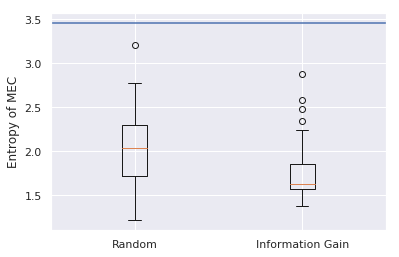

In [20]:
plt.boxplot([entropies_random, entropies_info], positions=[1, 2]);
plt.gca().set_xticklabels(['Random', 'Information Gain']);
plt.axhline(np.log2(len(mec))) # Original Entropy
plt.ylabel('Entropy of MEC');
fn = 'fig1_boxplot_simple_max_interventions=%s_nsamples=%s.png' % (max_interventions, nsamples)
plt.savefig(os.path.join(FIGURES_FOLDER, fn));